### Decision Tree

A **Decision Tree** is a supervised learning algorithm used for both **classification** and **regression** tasks. It splits the data into subsets based on feature values, creating a tree structure with the following:

- **Root Node**: The starting point where the first split is made.
- **Internal Nodes**: Points where further splits occur based on feature conditions.
- **Leaf Nodes**: Endpoints representing a class label (classification) or a predicted value (regression).

---

### Math Behind Decision Trees:

#### 1. Splitting Criterion:
The goal is to find the best split that:

- **Maximizes separation of classes** (for classification).
- **Minimizes prediction error** (for regression).

---

#### 2. Gini Impurity (Classification):
Gini impurity measures how mixed the classes are in a subset. A pure node has a Gini impurity of 0:

$$
\text{Gini Impurity} = 1 - \sum_{i=1}^C p_i^2
$$

Where:
- \(C\): Total number of classes.
- \(p_i\): Proportion of samples belonging to class \(i\) in the subset.

---

#### 3. Entropy (Classification):
Entropy measures the randomness in the target variable:

$$
\text{Entropy} = - \sum_{i=1}^C p_i \log_2(p_i)
$$

Where:
- \(p_i\): Proportion of samples belonging to class \(i\) in the subset.

---

#### 4. Information Gain (Classification):
Information Gain evaluates the reduction in entropy after a split:

$$
\text{Information Gain} = \text{Entropy(Parent)} - \sum_{\text{Children}} \frac{N_k}{N} \cdot \text{Entropy(Child)}
$$

Where:
- \(N_k\): Number of samples in child \(k\).
- \(N\): Total number of samples.

---

#### 5. Mean Squared Error (Regression):
For regression tasks, the quality of a split is measured by reducing variance. The Mean Squared Error is:

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \bar{y})^2
$$

Where:
- \(y_i\): True value of the target for sample \(i\).
- \(\bar{y}\): Mean of the target values in the subset.
- \(N\): Number of samples.

---

#### 6. Stopping Criteria:
The tree grows until:
1. A **maximum depth** is reached.
2. The **minimum number of samples per node** is met.
3. The impurity/error is below a **threshold**.

---

#### 7. Prediction:
- **Classification**: Assigns the majority class at the leaf node.
- **Regression**: Predicts the mean target value at the leaf node.

---

### Example Workflow (Classification):
1. Start with all data at the root node.
2. For each feature, calculate the splitting metric (e.g., Gini or Entropy) for all possible splits.
3. Choose the split with the **best metric value** (lowest Gini or highest Information Gain).
4. Repeat this process recursively for child nodes.
5. Stop splitting when stopping criteria are met.

---

### Key Takeaway:
A decision tree creates a flowchart-like structure by splitting data at each node to optimize a splitting criterion, ending at pure or nearly pure leaf nodes.


---
Python Practice
---
We will use the scikit-learn’s decision tree classifier to classify patients into liver patient (liver disease) or not (no disease). 

We will use a dataset of 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. 10 variables for each patient are recorded, and the true label is in column Dataset. The data is obtained through https://www.kaggle.com/datasets/uciml/indian-liver-patient-records. We will use the data stored in HW1_data.csv on the course website for this assignment.
You will build a KNN classifier to classify patients into liver patient (liver disease) or not (no disease).


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import StandardScaler,  LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Source
# setting random seed for reproducibility
np.random.seed(1210)

In [2]:
# path to data
data_path = "/Users/ahmadreza/Documents/Files/PhD Files/code/code_repository/algorithms/KNN/hw1_data.csv"

In [3]:
# Function for loading the data
def load_data(data_path: str) -> tuple[list, list, list]:
    # Load the dataset from the given CSV file
    df = pd.read_csv(data_path)
    print(df)
    
    # Initialize the encoder for categorical 'Gender' feature
    label_encoder = LabelEncoder()
    # Encode the 'Gender' column (Male: 0, Female: 1)
    df['Gender'] = label_encoder.fit_transform(df['Gender'])
    
    # Extract target labels from 'Dataset' column
    y = df["Dataset"].to_numpy()
    
    # Drop the target column from the feature set
    df = df.drop(columns=["Dataset"])
    
    # Convert features to numpy array
    X = df.to_numpy()
    
    # Handle NaN values by replacing them with 0
    X = np.nan_to_num(X)
    
    # Split the dataset into training + validation and testing sets (80% train + validation, 20% test)
    train_val_X, test_X, train_val_y, test_y = train_test_split(X, y, test_size=0.20)
    
    # Split the training + validation set into train and validation sets (90% train, 10% validation)
    train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=(0.10/0.80))
    
    # Return the train, validation, and test sets as tuples
    return [train_X, train_y], [val_X, val_y], [test_X, test_y]


In [6]:
# Load data
train, val, test = load_data(data_path)


     Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0     65  Female              0.7               0.1                   187   
1     62    Male             10.9               5.5                   699   
2     62    Male              7.3               4.1                   490   
3     58    Male              1.0               0.4                   182   
4     72    Male              3.9               2.0                   195   
..   ...     ...              ...               ...                   ...   
578   60    Male              0.5               0.1                   500   
579   40    Male              0.6               0.1                    98   
580   52    Male              0.8               0.2                   245   
581   31    Male              1.3               0.5                   184   
582   38    Male              1.0               0.3                   216   

     Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  

In [29]:
# Function to select the best k-NN model
def train_decision_tree(
        train: tuple[list, list],  # Training data and labels
        val: tuple[list, list],  # Validation data and labels
        test: tuple[list, list],  # Test data and labels
        standardization: bool = True,  # Whether to standardize data (default: True)
        criterion: str = 'gini',
        splitter:str = 'best',
        min_samples_leaf: int = 1,
        max_depth: int = None
) -> tree.DecisionTreeClassifier:
    
    # Extract data and labels for training, validation, and testing
    train_X, train_y = train[0], train[1]
    val_X, val_y = val[0], val[1]
    test_X, test_y = test[0], test[1]

    # If standardization is enabled, scale the features to have zero mean and unit variance
    if standardization:
        scaler = StandardScaler().fit(train_X)  # Fit scaler on training data
        train_X = scaler.transform(train_X)  # Apply transformation to training data
        val_X = scaler.transform(val_X)  # Apply transformation to validation data
        test_X = scaler.transform(test_X)  # Apply transformation to test data

    # train the DT model
    dt = tree.DecisionTreeClassifier(criterion=criterion,
                                     splitter=splitter, 
                                     min_samples_leaf=min_samples_leaf,
                                     max_depth=max_depth)  # Initialize DT classifier
                
    dt.fit(train_X, train_y)  # Train the k-NN model on the training data

    train_acc = dt.score(train_X, train_y)  # Append training accuracy
    val_acc = dt.score(val_X, val_y)  # Append validation accuracy
    test_acc = dt.score(test_X, test_y)  # Append validation accuracy

    # Convert accuracies to numpy arrays for plotting
    train_acc = np.array(train_acc)
    val_acc = np.array(val_acc)
    test_acc = np.array(test_acc)

    # Print the best model's k, training accuracy, validation accuracy, and test accuracy
    print(f"> train_acc = {train_acc}, val_acc = {val_acc}, test_acc = {test_acc}")

    return dt

In [30]:
model = train_decision_tree(
    train,
    val,
    test,
    True,
    'gini',
    'best',
    1,
)

> train_acc = 1.0, val_acc = 0.6440677966101694, test_acc = 0.5897435897435898


The model overfitted (training accuracy is very close to 1 while test accuracy is not) let's increase the min_sample_leaf and limit the max_depth.

In [31]:
model = train_decision_tree(
    train,
    val,
    test,
    True,
    'gini',
    'best',
    5,
    5
)

> train_acc = 0.7616707616707616, val_acc = 0.7966101694915254, test_acc = 0.717948717948718


[Text(0.5291666666666667, 0.9166666666666666, 'f3f4 <= -0.259\ngini = 0.418\nsamples = 407\nvalue = [286, 121]'),
 Text(0.3416666666666667, 0.75, 'f7 <= -0.075\ngini = 0.483\nsamples = 257\nvalue = [152, 105]'),
 Text(0.4354166666666667, 0.8333333333333333, 'True  '),
 Text(0.21666666666666667, 0.5833333333333334, 'f6 <= -0.346\ngini = 0.496\nsamples = 225\nvalue = [123.0, 102.0]'),
 Text(0.13333333333333333, 0.4166666666666667, 'f1 <= -1.011\ngini = 0.5\nsamples = 159\nvalue = [78, 81]'),
 Text(0.06666666666666667, 0.25, 'f9 <= 1.09\ngini = 0.408\nsamples = 28\nvalue = [8, 20]'),
 Text(0.03333333333333333, 0.08333333333333333, 'gini = 0.287\nsamples = 23\nvalue = [4, 19]'),
 Text(0.1, 0.08333333333333333, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.2, 0.25, 'f3f4 <= -0.323\ngini = 0.498\nsamples = 131\nvalue = [70, 61]'),
 Text(0.16666666666666666, 0.08333333333333333, 'gini = 0.493\nsamples = 122\nvalue = [68, 54]'),
 Text(0.23333333333333334, 0.08333333333333333, 'gini = 0.

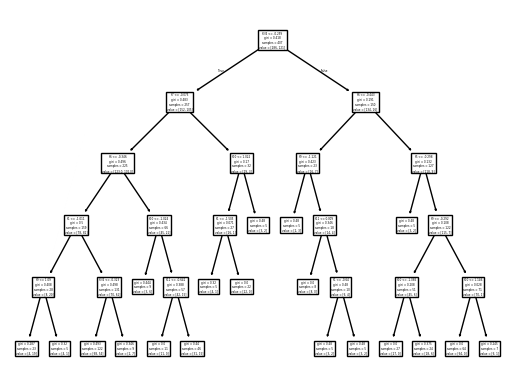

In [32]:
tree.plot_tree(model, feature_names=['f1', 'f2', 'f3' 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'])